In [1]:
import torch


def activation_func(activation_fn):
    '''
    Select activation function
    Arg(s):
        activation_fn : str
            name of activation function
    '''

    if 'linear' in activation_fn:
        return None
    elif 'leaky_relu' in activation_fn:
        return torch.nn.LeakyReLU(negative_slope=0.20, inplace=True)
    elif 'relu' in activation_fn:
        return torch.nn.ReLU()
    elif 'elu' in activation_fn:
        return torch.nn.ELU()
    elif 'sigmoid' in activation_fn:
        return torch.nn.Sigmoid()
    else:
        raise ValueError('Unsupported activation function: {}'.format(activation_fn))

In [17]:
class Conv2d(torch.nn.Module):
    '''
    2D convolution class

    Arg(s):
        in_channels : int
            number of input channels
        out_channels : int
            number of output channels
        kernel_size : int
            size of kernel
        stride : int
            stride of convolution
        weight_initializer : str
            kaiming_normal, kaiming_uniform, xavier_normal, xavier_uniform
        activation_func : func
            activation function after convolution
        use_batch_norm : bool
            if set, then applied batch normalization
    '''

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 weight_initializer='kaiming_uniform',
                 activation_func=torch.nn.LeakyReLU(negative_slope=0.10, inplace=True),
                 use_batch_norm=False):
        super(Conv2d, self).__init__()

        self.use_batch_norm = use_batch_norm
        padding = kernel_size // 2

        self.conv = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False)

        # Select the type of weight initialization, by default kaiming_uniform
        if weight_initializer == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(self.conv.weight)
        elif weight_initializer == 'xavier_normal':
            torch.nn.init.xavier_normal_(self.conv.weight)
        elif weight_initializer == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(self.conv.weight)

        self.activation_func = activation_func

        if self.use_batch_norm:
            self.batch_norm = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        conv = self.conv(x)
        conv = self.batch_norm(conv) if self.use_batch_norm else conv

        if self.activation_func is not None:
            return self.activation_func(conv)
        else:
            return conv

In [105]:
class TransposeConv2d(torch.nn.Module):
    '''
    Transpose convolution class

    Arg(s):
        in_channels : int
            number of input channels
        out_channels : int
            number of output channels
        kernel_size : int
            size of kernel (k x k)
        weight_initializer : str
            kaiming_normal, kaiming_uniform, xavier_normal, xavier_uniform
        activation_func : func
            activation function after convolution
        use_batch_norm : bool
            if set, then applied batch normalization
    '''

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 weight_initializer='kaiming_uniform',
                 activation_func=torch.nn.LeakyReLU(negative_slope=0.10, inplace=True),
                 use_batch_norm=False):
        super(TransposeConv2d, self).__init__()

        self.use_batch_norm = use_batch_norm
        padding = kernel_size // 2

        self.deconv = torch.nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=2,
            padding=padding,
            output_padding=1,
            bias=False)

        # Select the type of weight initialization, by default kaiming_uniform
        if weight_initializer == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(self.conv.weight)
        elif weight_initializer == 'xavier_normal':
            torch.nn.init.xavier_normal_(self.conv.weight)
        elif weight_initializer == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(self.conv.weight)

        self.activation_func = activation_func

        if self.use_batch_norm:
            self.batch_norm = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        deconv = self.deconv(x)
        deconv = self.batch_norm(deconv) if self.use_batch_norm else deconv
        if self.activation_func is not None:
            return self.activation_func(deconv)
        else:
            return deconv
        
class FullyConnected(torch.nn.Module):
    '''
    Fully connected layer

    Arg(s):
        in_channels : int
            number of input neurons
        out_channels : int
            number of output neurons
        dropout_rate : float
            probability to use dropout
    '''

    def __init__(self,
                 in_features,
                 out_features,
                 weight_initializer='kaiming_uniform',
                 activation_func=torch.nn.LeakyReLU(negative_slope=0.10, inplace=True),
                 dropout_rate=0.00):
        super(FullyConnected, self).__init__()

        self.fully_connected = torch.nn.Linear(in_features, out_features)

        if weight_initializer == 'kaiming_normal':
            torch.nn.init.kaiming_normal_(self.fully_connected.weight)
        elif weight_initializer == 'xavier_normal':
            torch.nn.init.xavier_normal_(self.fully_connected.weight)
        elif weight_initializer == 'xavier_uniform':
            torch.nn.init.xavier_uniform_(self.fully_connected.weight)

        self.activation_func = activation_func

        if dropout_rate > 0.00 and dropout_rate <= 1.00:
            self.dropout = torch.nn.Dropout(p=dropout_rate)
        else:
            self.dropout = None

    def forward(self, x):
        fully_connected = self.fully_connected(x)

        if self.activation_func is not None:
            fully_connected = self.activation_func(fully_connected)

        if self.dropout is not None:
            return self.dropout(fully_connected)
        else:
            return fully_connected
class ResNetBlock(torch.nn.Module):
    '''
    Basic ResNet block class
    Arg(s):
        in_channels : int
            number of input channels
        out_channels : int
            number of output channels
        stride : int
            stride of convolution
        weight_initializer : str
            kaiming_normal, kaiming_uniform, xavier_normal, xavier_uniform
        activation_func : func
            activation function after convolution
        use_batch_norm : bool
            if set, then applied batch normalization
    '''

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1,
                 weight_initializer='kaiming_uniform',
                 activation_func=torch.nn.LeakyReLU(negative_slope=0.10, inplace=True),
                 use_batch_norm=False):
        super(ResNetBlock, self).__init__()

        self.activation_func = activation_func

        self.conv1 = Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            weight_initializer=weight_initializer,
            activation_func=activation_func,
            use_batch_norm=use_batch_norm)

        self.conv2 = Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            weight_initializer=weight_initializer,
            activation_func=activation_func,
            use_batch_norm=use_batch_norm)

        self.projection = Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
            stride=stride,
            weight_initializer=weight_initializer,
            activation_func=None,
            use_batch_norm=False)

    def forward(self, x):
        # Perform 2 convolutions
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)

        # Perform projection if (1) shape does not match (2) channels do not match
        in_shape = list(x.shape)
        out_shape = list(conv2.shape)
        if in_shape[2:4] != out_shape[2:4] or in_shape[1] != out_shape[1]:
            X = self.projection(x)
        else:
            X = x

        # f(x) + x
        return self.activation_func(conv2 + X)      

In [110]:
ten = torch.randn((1,1,4,4))

In [107]:
test = ten.unsqueeze(0).unsqueeze(0)

In [111]:
test.shape

torch.Size([1, 1, 4, 4])

In [113]:
ten

tensor([[[[-0.6770, -0.3093, -1.0020,  1.6975],
          [-0.2761, -0.8522,  0.4192, -0.3670],
          [-2.2015, -0.1245, -0.0280,  0.6368],
          [ 1.2628,  0.4008,  0.5427, -0.2467]]]])

In [68]:
layer_1 = Conv2d(in_channels=1,out_channels=16)
layer_2 = TransposeConv2d(in_channels=16,out_channels=8)
layer_3 = FullyConnected(in_features=8,out_features=2)


In [127]:

block1 = ResNetBlock(in_channels=1,out_channels=16)
x = block1(ten)
print(x.shape)

torch.Size([1, 16, 4, 4])


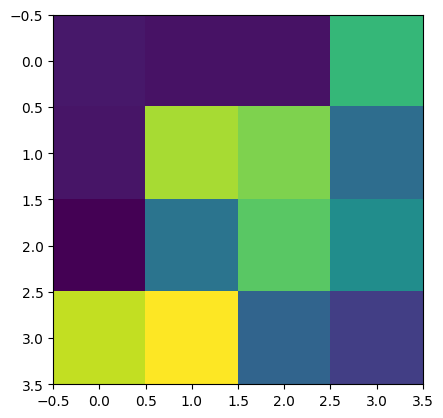

In [126]:
plt.imshow(x.squeeze(0)[0].detach().cpu().numpy())

In [69]:
x = layer_1(test)
x.shape

torch.Size([1, 16, 4, 4])

In [70]:
x = layer_2(x)
x.shape

torch.Size([1, 8, 8, 8])

In [71]:
x = layer_3(x)
x.shape

torch.Size([1, 8, 8, 2])

In [10]:
ten = torch.randn((4,4))
x = activation_func('relu')
x(ten)

tensor([[0.0000, 0.1746, 0.0000, 0.0000],
        [0.4597, 2.2726, 0.0000, 0.6749],
        [0.7336, 0.0000, 0.7044, 0.0000],
        [0.0250, 0.3271, 1.1977, 0.0000]])

In [11]:
x = activation_func('elu')
x(ten)

tensor([[-0.0924,  0.1746, -0.1188, -0.7212],
        [ 0.4597,  2.2726, -0.4107,  0.6749],
        [ 0.7336, -0.1322,  0.7044, -0.2247],
        [ 0.0250,  0.3271,  1.1977, -0.6648]])

In [12]:
x = activation_func('leaky_relu')
x(ten)

tensor([[-0.0194,  0.1746, -0.0253, -0.2554],
        [ 0.4597,  2.2726, -0.1058,  0.6749],
        [ 0.7336, -0.0284,  0.7044, -0.0509],
        [ 0.0250,  0.3271,  1.1977, -0.2186]])

In [95]:
x = activation_func('sigmoid')
x(ten)

tensor([[0.4952, 0.5435, 0.4937, 0.4365],
        [0.6130, 0.9066, 0.4736, 0.6626],
        [0.6756, 0.4929, 0.6692, 0.4873],
        [0.5063, 0.5811, 0.7681, 0.4456]])

In [16]:
0.0194-0.5

-0.4806